In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os

from CLAPWrapper import CLAPWrapper
from utils.dataset import *
from utils.interventions import Intervention
from utils.activations import save_dataset_activations, clear_hooks
from utils.layerwise import save_pairwise_distances

from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from einops import rearrange
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from icecream import ic
from tqdm.autonotebook import tqdm
from IPython.display import IFrame
from wand.image import Image as WImage

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
seed_everything(42)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),    # 0
    'audio_encoder.base.conv_block2': nn.Identity(),    # 1
    'audio_encoder.base.conv_block3': nn.Identity(),    # 2
    'audio_encoder.base.conv_block4': nn.Identity(),    # 3
    'audio_encoder.base.conv_block5': nn.Identity(),    # 4
    'audio_encoder.base.conv_block6': nn.Identity(),    # 5
    'audio_encoder.base.fc1': F.relu,                   # 6
    'audio_encoder.projection.linear1': F.gelu,         # 7
    'audio_encoder.projection.linear2': nn.Identity(),  # 8
}

module_list = list(module_activation_dict.keys())

In [6]:
weights_path = "/scratch/pratyaksh.g/clap/CLAP_weights_2022_microsoft.pth"
clap_model = CLAPWrapper(weights_path, use_cuda=True if DEVICE == "cuda" else False)

In [7]:
clap_model.clap.eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [8]:
probing_dataset = ESC50Dataset()
testing_dataset = ESC50Dataset()

Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


2000it [00:00, 10200.74it/s]

Loading audio files


Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


778it [00:00, 7774.08it/s]

Loading audio files


2000it [00:00, 8704.21it/s]


In [9]:
layer_idx = 6
layer_name = module_list[layer_idx]
partition_idx = 2
cluster_idx = 1

In [10]:
activations = torch.load(f'/scratch/pratyaksh.g/{testing_dataset.path_name}/activations/{layer_name}.pt')
clusters = torch.load(f'/scratch/pratyaksh.g/{probing_dataset.path_name}/clusters/{layer_name}.pt')
n_clusters = torch.load(f'/scratch/pratyaksh.g/{probing_dataset.path_name}/clusters/{layer_name}_n.pt')

In [11]:
if len(activations.shape) > 2:
    n, c, w, h = activations.shape

In [12]:
pdf_path = f'/scratch/pratyaksh.g/{probing_dataset.path_name}/cluster-plots/{layer_name}/partition-{partition_idx}/'

for file in os.listdir(pdf_path):
    if file.endswith(f'cluster-{cluster_idx}.pdf'):
        file_path = os.path.join(pdf_path, file)
        break

print('sftp://gnode060' + file_path)
IFrame(file_path, width=800, height=600)

sftp://gnode060/scratch/pratyaksh.g/esc50/cluster-plots/audio_encoder.base.fc1/partition-2/1-cluster-1.pdf


In [13]:
# Computing text embeddings
prompt = 'this is a sound of '
y = [prompt + x for x in testing_dataset.classes]
text_embeddings = clap_model.get_text_embeddings(y)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home2/pratyaksh.g/miniconda3/envs/ms-clap/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
performance = pd.DataFrame(
    columns=['accuracy', 'treatment', 'label']
)

## Normal performance

In [11]:
# Computing audio embeddings
embeddings = torch.load(f'/scratch/pratyaksh.g/{testing_dataset.path_name}/activations/embeddings.pt')

y_preds, y_labels = [], []
for idx, datum in enumerate(tqdm(testing_dataset)):
    x, _, one_hot_target = datum
    audio_embeddings = embeddings[idx].unsqueeze(0)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()
    y_pred = np.argmax(y_pred, axis=1)
    y_preds.append(y_pred)

    y_label = np.argmax(one_hot_target.detach().cpu().numpy(), axis=0)
    y_labels.append(y_label)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
confusion = confusion_matrix(y_labels, y_preds)
class_wise_acc = confusion.diagonal() / confusion.sum(axis=1)

for label_idx, label in enumerate(testing_dataset.classes):
    performance = performance.append({
        'accuracy': class_wise_acc[label_idx],
        'treatment': 'normal',
        'label': label,
    }, ignore_index=True)

In [13]:
performance

,accuracy,treatment,label
0,0.925,normal,dog
1,1.000,normal,rooster
2,0.900,normal,pig
3,0.625,normal,cow
4,0.975,normal,frog
5,0.950,normal,cat
6,0.975,normal,hen
7,0.725,normal,insects
8,0.925,normal,sheep
9,0.350,normal,crow


In [15]:
performance.to_csv('/scratch/pratyaksh.g/esc50/intervened-plots/normal-performance.csv')

## Intervened performance

In [ ]:
intervention = Intervention(clap_model, module_activation_dict)

In [ ]:
intervention.clear_handles()

# cluster_mask = torch.ones_like(clusters[:, partition_idx] == cluster_idx)
# cluster_mask[4] = 0
# cluster_mask = cluster_mask.bool()

cluster_mask = (clusters[:, partition_idx] == cluster_idx).bool()
# cluster_mask = ~(cluster_mask)

if len(cluster_mask.shape) > 2:
    cluster_mask = rearrange(cluster_mask, '(c w h) -> c w h', c=c, w=w, h=h)
intervention.set_intervention(activations, cluster_mask, layer_name, replace_with='random')

In [ ]:
# Computing audio embeddings
y_preds, y_labels = [], []
for datum in tqdm(testing_dataset):
    x, _, one_hot_target = datum
    audio_embeddings = clap_model.get_audio_embeddings([x], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()
    y_pred = np.argmax(y_pred, axis=1)
    y_preds.append(y_pred)

    y_label = np.argmax(one_hot_target.detach().cpu().numpy(), axis=0)
    y_labels.append(y_label)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
confusion = confusion_matrix(y_labels, y_preds)
class_wise_acc = confusion.diagonal() / confusion.sum(axis=1)

for label_idx, label in enumerate(testing_dataset.classes):
    performance = performance.append({
        'accuracy': class_wise_acc[label_idx],
        'treatment': 'intervened',
        'label': label,
    }, ignore_index=True)

In [ ]:
performance

,accuracy,treatment,label
0,0.925,normal,dog
1,1.000,normal,rooster
2,0.900,normal,pig
3,0.625,normal,cow
4,0.975,normal,frog
...,...,...,...
95,0.975,intervened,train
96,1.000,intervened,church bells
97,0.925,intervened,airplane
98,1.000,intervened,fireworks


## Random intervention performance

In [ ]:
num_neurons = clusters.shape[0]
num_neurons_in_cluster = cluster_mask.sum().item()
random_neurons = np.random.randint(0, num_neurons, num_neurons_in_cluster)
random_cluster_mask = torch.zeros_like(cluster_mask.flatten())
random_cluster_mask[random_neurons] = 1
random_cluster_mask = random_cluster_mask.bool()

In [ ]:
intervention = Intervention(clap_model, module_activation_dict)

In [ ]:
intervention.clear_handles()
if len(cluster_mask.shape) > 2:
    random_cluster_mask = rearrange(random_cluster_mask, '(c w h) -> c w h', c=c, w=w, h=h)
intervention.set_intervention(activations, random_cluster_mask, layer_name, replace_with='random')

In [ ]:
# Computing audio embeddings
y_preds, y_labels = [], []
for datum in tqdm(testing_dataset):
    x, _, one_hot_target = datum
    audio_embeddings = clap_model.get_audio_embeddings([x], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()
    y_pred = np.argmax(y_pred, axis=1)
    y_preds.append(y_pred)

    y_label = np.argmax(one_hot_target.detach().cpu().numpy(), axis=0)
    y_labels.append(y_label)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
confusion = confusion_matrix(y_labels, y_preds)
class_wise_acc = confusion.diagonal() / confusion.sum(axis=1)

for label_idx, label in enumerate(testing_dataset.classes):
    performance = performance.append({
        'accuracy': class_wise_acc[label_idx],
        'treatment': 'random',
        'label': label,
    }, ignore_index=True)

In [ ]:
intervention.clear_handles()
clear_hooks()

In [ ]:
performance

,accuracy,treatment,label


## Plots

In [ ]:
plot_path = f'/scratch/pratyaksh.g/{testing_dataset.path_name}/intervened-plots/{layer_name}/'
os.makedirs(plot_path, exist_ok=True)

In [ ]:
performance.to_csv(plot_path + f'intervention-{layer_name}-p{partition_idx}-c{cluster_idx}-pd-{layer_name}-performance.csv', index=False)

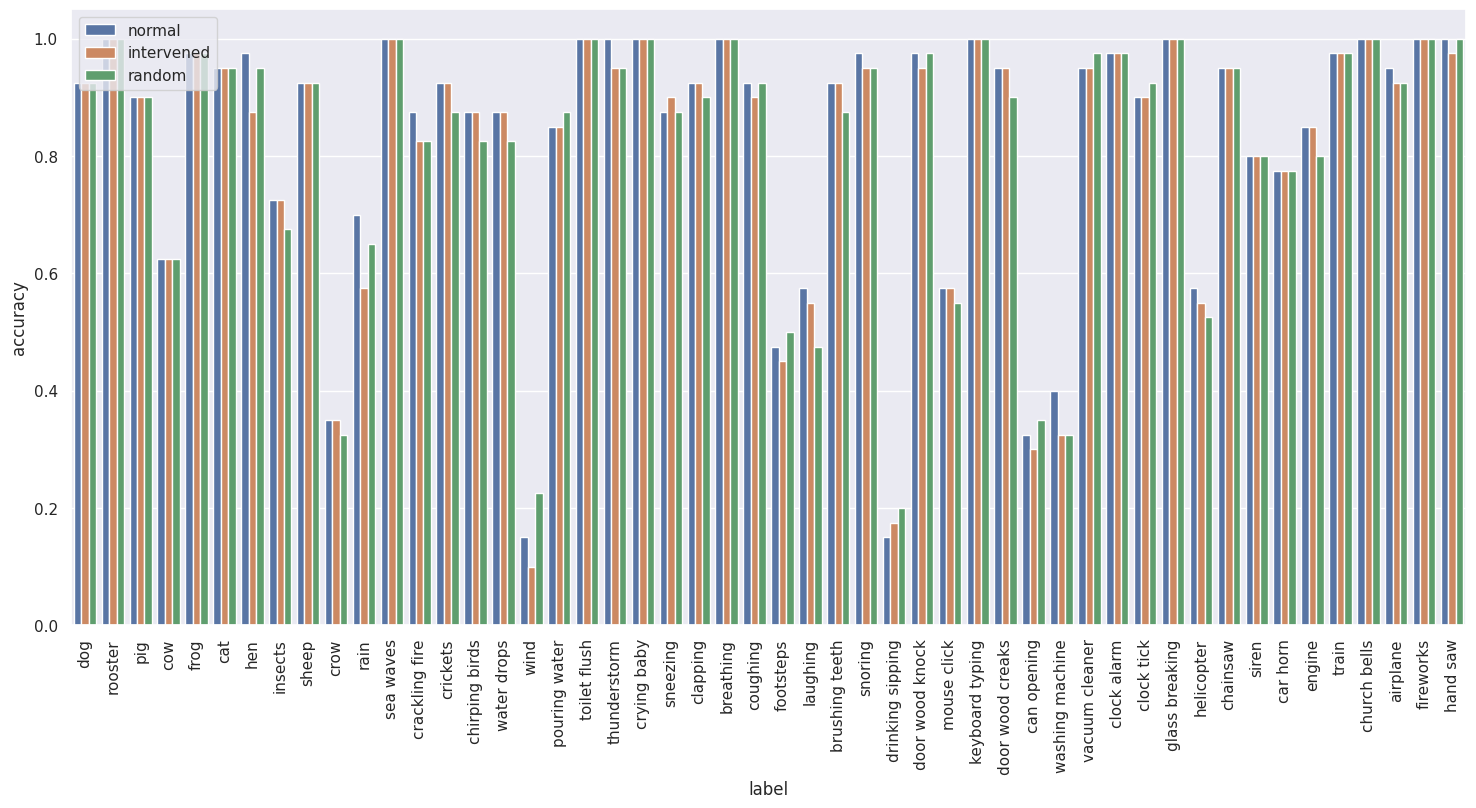

In [ ]:
plt.figure(figsize=(18, 8))
sns.set_theme()
# put the seaborn default orange and blue in the pallette
sns.barplot(data=performance, x='label', y='accuracy', hue='treatment')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.savefig(plot_path + f'p{partition_idx}-c{cluster_idx}-{probing_dataset.path_name}.png')